## Importing datasets and packages

We will begin with importing all relevant datasets and packages needed in order to create our model.

In [105]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna

/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [65]:
#load smote_train_data for training data and transformed_data for evaluation
smote_train_data_folder_path = '/Users/joanwong/Desktop/cs3244/finalised_datasets/smote_train_data'
transformed_data_folder_path = '/Users/joanwong/Desktop/cs3244/finalised_datasets/transformed_data'

smote_files = ['smote_fold_1.csv', 'smote_fold_2.csv', 'smote_fold_3.csv', 'smote_fold_4.csv', 'smote_fold_5.csv']
non_smote_files = ['fold_1.csv', 'fold_2.csv','fold_3.csv', 'fold_4.csv', 'fold_5.csv']


testing_data = pd.read_csv('/Users/joanwong/Desktop/cs3244/finalised_datasets/transformed_data/test_set.csv')
testing_data = testing_data.drop(columns = ['client_id', 'creation_date'])


# Preparing testing dataset

In [66]:
X_test= testing_data[features_for_selection]
Y_test = testing_data['fraud_status'].astype(int)

# Feature Selection

## RFECV

Fold 1: Performing RFECV for feature selection...
Number of features selected by RFECV for Fold 1: 4
Selected features using RFECV: Index(['consumption_level_3_sum', 'meter_number_count', 'meter_code_count',
       'reading_remark_8'],
      dtype='object')


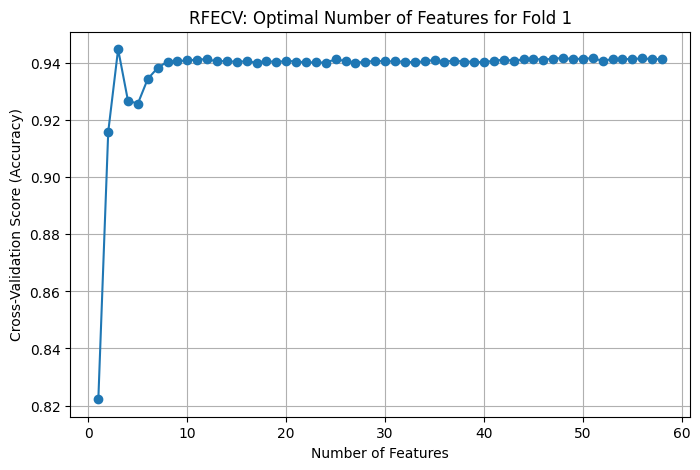

RFECV Fold 1: Accuracy = 0.9208
Fold 2: Performing RFECV for feature selection...
Number of features selected by RFECV for Fold 2: 2
Selected features using RFECV: Index(['months_number_max', 'meter_number_count'], dtype='object')


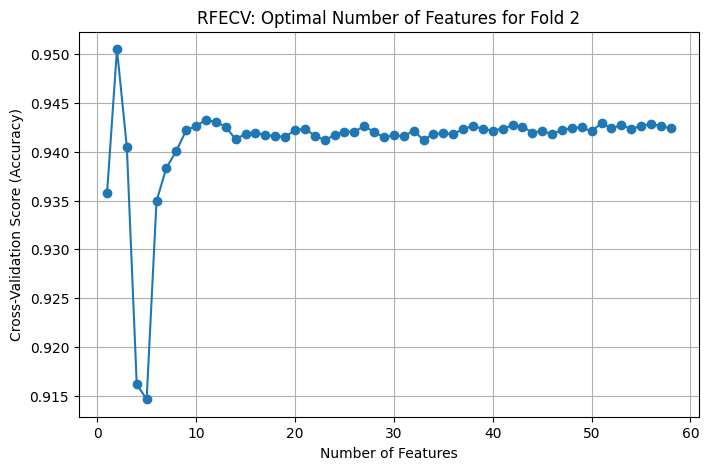

RFECV Fold 2: Accuracy = 0.9442
Fold 3: Performing RFECV for feature selection...
Number of features selected by RFECV for Fold 3: 2
Selected features using RFECV: Index(['meter_number_count', 'reading_remark_8'], dtype='object')


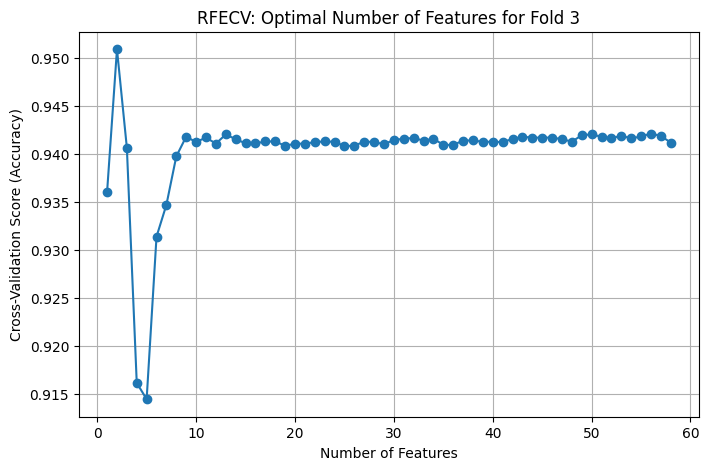

RFECV Fold 3: Accuracy = 0.9446
Fold 4: Performing RFECV for feature selection...
Number of features selected by RFECV for Fold 4: 4
Selected features using RFECV: Index(['consumption_level_3_mean', 'meter_number_count', 'meter_code_count',
       'reading_remark_8'],
      dtype='object')


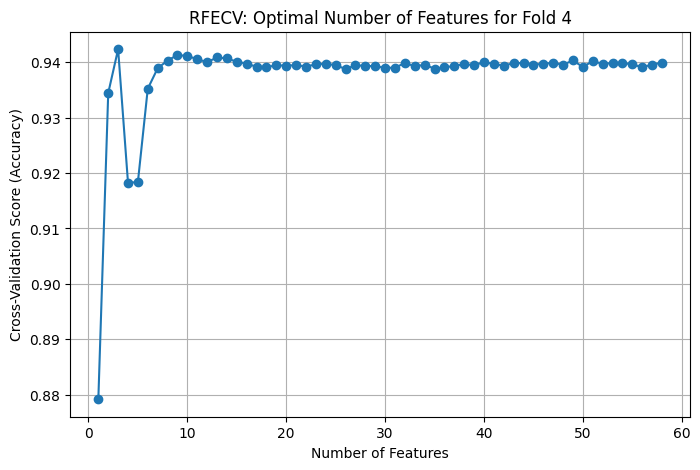

RFECV Fold 4: Accuracy = 0.9164
Fold 5: Performing RFECV for feature selection...
Number of features selected by RFECV for Fold 5: 4
Selected features using RFECV: Index(['consumption_level_3_max', 'months_number_max', 'meter_number_count',
       'reading_remark_8'],
      dtype='object')


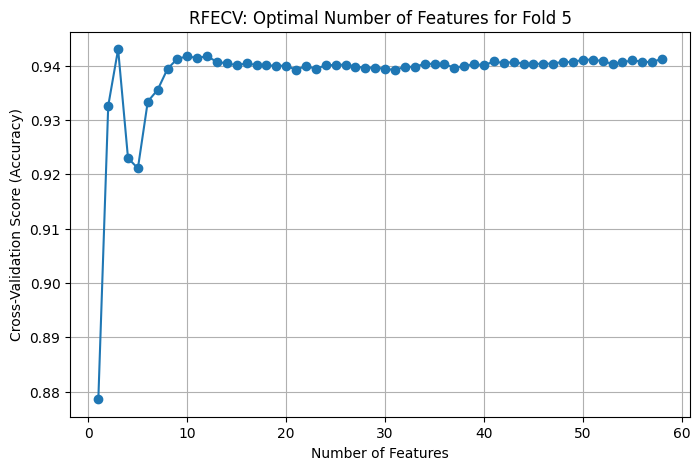

RFECV Fold 5: Accuracy = 0.9260


In [71]:
# Custom cross-validation using RFECV
feature_counts_rfecv = []  # Track number of features selected for each fold

# Custom cross-validation using RFECV
for i in range(len(smote_files)):
    # Define training and testing sets
    train_smote_files = [file for j, file in enumerate(smote_files) if j != i]  # All folds except the i-th for training
    test_non_smote_file = non_smote_files[i]  # Corresponding non-smoted fold for testing

    # Load SMOTE training data
    train_dataframes = []
    for file in train_smote_files:
        file_path = os.path.join(smote_train_data_folder_path, file)
        df = pd.read_csv(file_path)
        train_dataframes.append(df)

    # Concatenate SMOTE training data
    train_data = pd.concat(train_dataframes, ignore_index=True)

    # Load non-SMOTE validation data
    test_file_path = os.path.join(smote_train_data_folder_path, test_non_smote_file)
    test_data = pd.read_csv(test_file_path)

    # Split features and target
    features = train_data.columns.drop('fraud_status')
    X_train = train_data[features]
    y_train = train_data['fraud_status']
    X_test = test_data[features]
    y_test = test_data['fraud_status']

    ## Step 1: Feature Selection using RFECV
    print(f"Fold {i+1}: Performing RFECV for feature selection...")
    model = DecisionTreeClassifier(random_state=42)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3-fold cross-validation within each fold
    rfecv = RFECV(estimator=model, step=2, cv=cv, scoring='accuracy', n_jobs=-1)
    rfecv.fit(X_train, y_train)

    # Select the optimal features using RFECV
    selected_features_rfecv = X_train.columns[rfecv.support_]
    feature_counts_rfecv.append(len(selected_features_rfecv))  # Append feature count
    print(f"Number of features selected by RFECV for Fold {i+1}: {len(selected_features_rfecv)}")
    print("Selected features using RFECV:", selected_features_rfecv)

    # Plot the number of features vs cross-validation score
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('Cross-Validation Score (Accuracy)')
    plt.title(f'RFECV: Optimal Number of Features for Fold {i + 1}')
    plt.grid(True)
    plt.show()

    # Train model with selected features (RFECV)
    X_train_rfecv = X_train[selected_features_rfecv]
    X_test_rfecv = X_test[selected_features_rfecv]
    model.fit(X_train_rfecv, y_train)
    y_pred_rfecv = model.predict(X_test_rfecv)
    accuracy_rfecv = accuracy_score(y_test, y_pred_rfecv)
    print(f"RFECV Fold {i+1}: Accuracy = {accuracy_rfecv:.4f}")



In [93]:
# Summarize feature counts across folds
mode_features_rfecv = stats.mode(feature_counts_rfecv)
median_features_rfecv = np.median(feature_counts_rfecv)
print(mode_features_rfecv)
print(f"Median number of features selected by RFECV across all folds: {median_features_rfecv:.2f}")

ModeResult(mode=np.int64(4), count=np.int64(3))
Median number of features selected by RFECV across all folds: 4.00


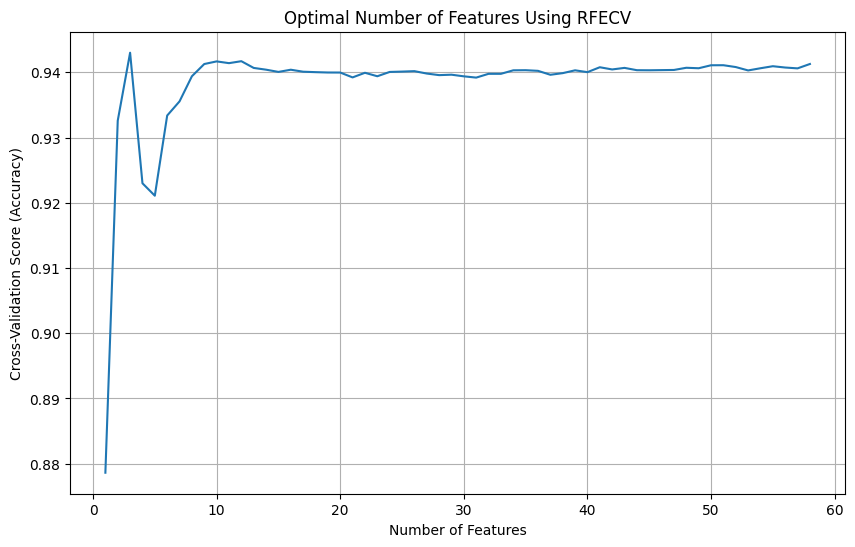

In [92]:
# Plot the number of features vs cross-validation score
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Score (Accuracy)')
plt.title('Optimal Number of Features Using RFECV')
plt.grid()
plt.show()


## Mutual Information

Fold 1: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 1: 4
Selected features using Mutual Information: Index(['is_index_discrepancy_False', 'meter_coefficient_1', 'meter_status_0.0',
       'no_of_invoices'],
      dtype='object')


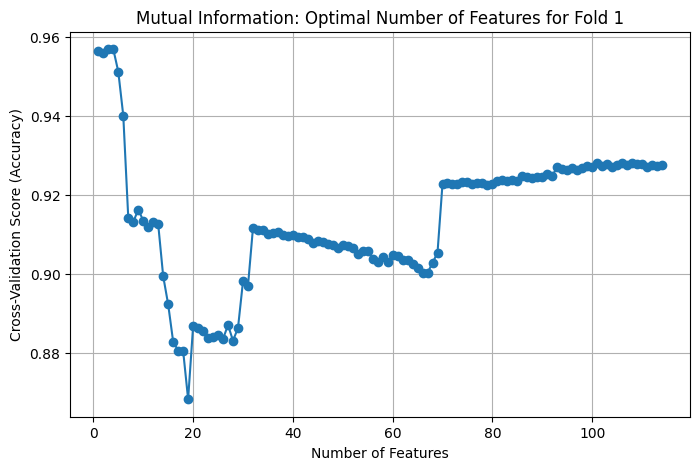

Mutual Information Fold 1: Accuracy = 0.9432
Fold 2: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 2: 2
Selected features using Mutual Information: Index(['meter_status_0.0', 'is_index_discrepancy_False'], dtype='object')


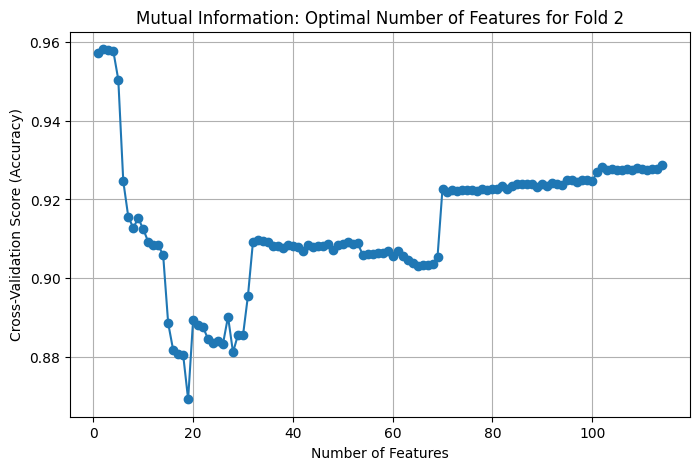

Mutual Information Fold 2: Accuracy = 0.9429
Fold 3: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 3: 3
Selected features using Mutual Information: Index(['meter_status_0.0', 'meter_coefficient_1', 'no_of_invoices'], dtype='object')


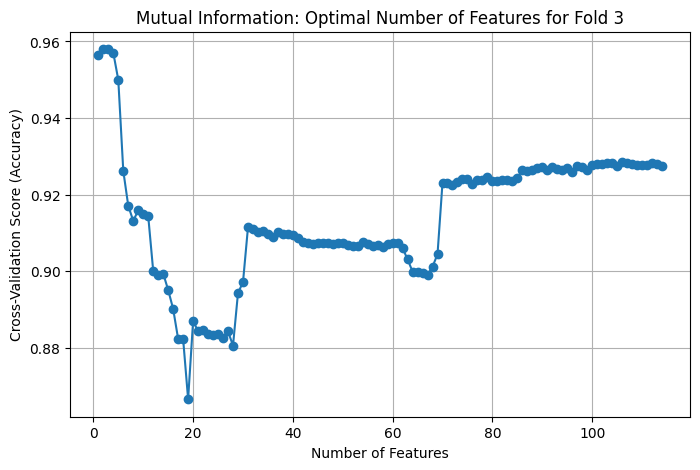

Mutual Information Fold 3: Accuracy = 0.9435
Fold 4: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 4: 2
Selected features using Mutual Information: Index(['is_index_discrepancy_False', 'meter_status_0.0'], dtype='object')


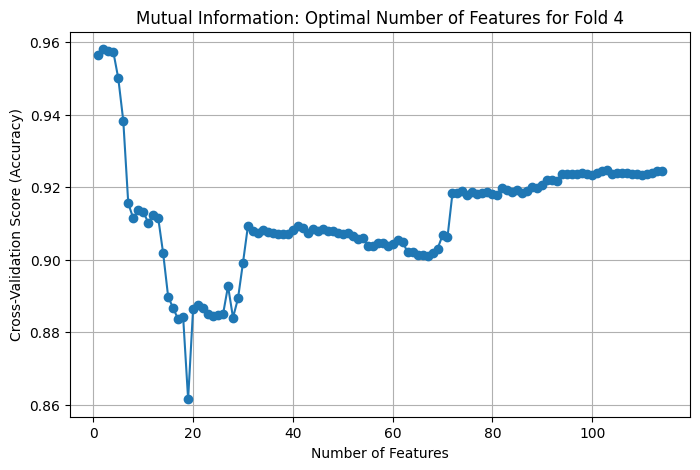

Mutual Information Fold 4: Accuracy = 0.9432
Fold 5: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 5: 2
Selected features using Mutual Information: Index(['meter_status_0.0', 'is_index_discrepancy_False'], dtype='object')


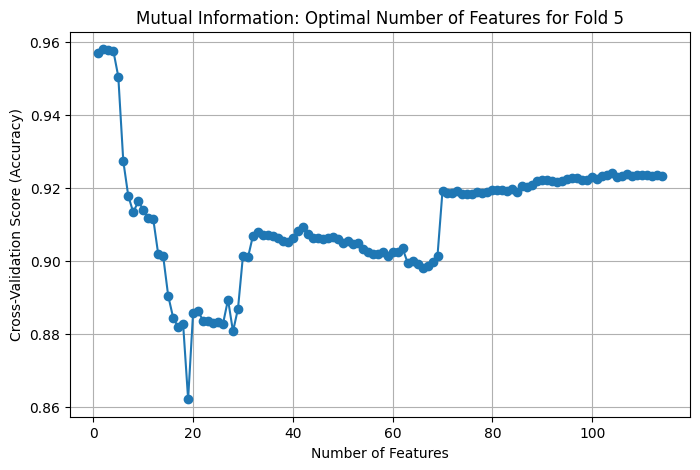

Mutual Information Fold 5: Accuracy = 0.9426


In [89]:
# Custom cross-validation using Mutual Information
for i in range(len(smote_files)):
    # Define training and testing sets
    train_smote_files = [file for j, file in enumerate(smote_files) if j != i]  # All folds except the i-th for training
    test_non_smote_file = non_smote_files[i]  # The corresponding non-smoted fold for testing

    # Load training data
    train_dataframes = []
    for file in train_smote_files:
        file_path = os.path.join(smote_train_data_folder_path, file)
        df = pd.read_csv(file_path)
        train_dataframes.append(df)

    # Concatenate training data
    train_data = pd.concat(train_dataframes, ignore_index=True)

    # Load testing data
    test_file_path = os.path.join(smote_train_data_folder_path, test_non_smote_file)
    test_data = pd.read_csv(test_file_path)

    # Split features and target
    features = train_data.columns.drop('fraud_status')
    X_train = train_data[features]
    y_train = train_data['fraud_status']
    X_test = test_data[features]
    y_test = test_data['fraud_status']

    # Step 1: Feature Selection using Mutual Information
    print(f"Fold {i+1}: Performing Mutual Information for feature selection...")
    mutual_info = mutual_info_classif(X_train, y_train)
    mutual_info_series = pd.Series(mutual_info, index=X_train.columns).sort_values(ascending=False)
    scores = []

    # Determine optimal number of features using cross-validation
    best_score = 0
    optimal_k = 0
    for k in range(1, len(mutual_info_series) + 1):
        selected_features = mutual_info_series.head(k).index
        X_train_selected = X_train[selected_features]
        score = cross_val_score(model, X_train_selected, y_train, cv=3, scoring='accuracy').mean()
        scores.append(score)

        if score > best_score:
            best_score = score
            optimal_k = k

    print(f"Optimal number of features based on cross-validation for Fold {i + 1}: {optimal_k}")
    selected_features_mi_optimal = mutual_info_series.head(optimal_k).index
    print("Selected features using Mutual Information:", selected_features_mi_optimal)

    # Plot the cross-validation scores vs. number of features
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(mutual_info_series) + 1), scores, marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('Cross-Validation Score (Accuracy)')
    plt.title(f'Mutual Information: Optimal Number of Features for Fold {i + 1}')
    plt.grid(True)
    plt.show()

    X_train_mi = X_train[selected_features_mi_optimal]
    X_test_mi = X_test[selected_features_mi_optimal]

    # Step 2: Train model with selected features (Mutual Information)
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train_mi, y_train)
    y_pred_mi = model.predict(X_test_mi)
    accuracy_mi = accuracy_score(y_test, y_pred_mi)
    print(f"Mutual Information Fold {i+1}: Accuracy = {accuracy_mi:.4f}")

In [98]:
# Custom cross-validation using Mutual Information
feature_counts_mi =  [4, 2, 3, 2, 2] # Track number of features selected for each fold
selected_features_mi_all_folds = [
       ['is_index_discrepancy_False', 'meter_coefficient_1', 'meter_status_0.0','no_of_invoices'],
       ['meter_status_0.0', 'is_index_discrepancy_False'],
       ['meter_status_0.0', 'meter_coefficient_1', 'no_of_invoices'],
       ['is_index_discrepancy_False', 'meter_status_0.0'],
       ['meter_status_0.0', 'is_index_discrepancy_False']
       ]

In [99]:
# Summarize feature counts across folds for Mutual Information
average_features_mi = np.mean(feature_counts_mi)
median_features_mi = np.median(feature_counts_mi)
print(f"Average number of features selected by Mutual Information across all folds: {average_features_mi:.2f}")
print(f"Median number of features selected by Mutual Information across all folds: {median_features_mi:.2f}")
print("Selected features across all folds using Mutual Information:")
for fold_idx, features in enumerate(selected_features_mi_all_folds, 1):
    print(f"Fold {fold_idx}: {list(features)}")

Average number of features selected by Mutual Information across all folds: 2.60
Median number of features selected by Mutual Information across all folds: 2.00
Selected features across all folds using Mutual Information:
Fold 1: ['is_index_discrepancy_False', 'meter_coefficient_1', 'meter_status_0.0', 'no_of_invoices']
Fold 2: ['meter_status_0.0', 'is_index_discrepancy_False']
Fold 3: ['meter_status_0.0', 'meter_coefficient_1', 'no_of_invoices']
Fold 4: ['is_index_discrepancy_False', 'meter_status_0.0']
Fold 5: ['meter_status_0.0', 'is_index_discrepancy_False']


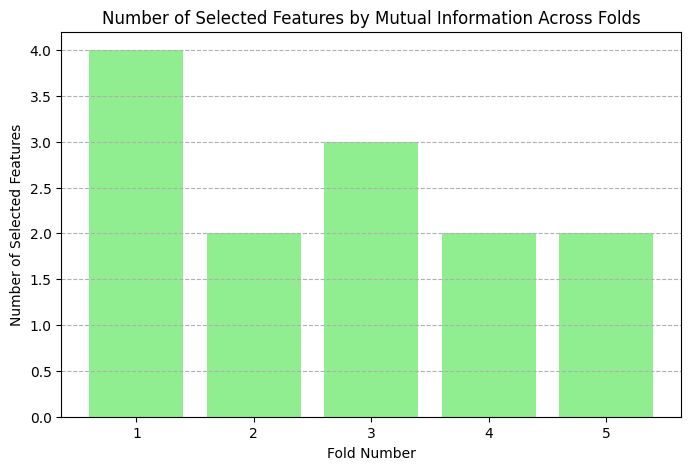

In [100]:
# Plot the distribution of the number of selected features across folds for Mutual Information
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(feature_counts_mi) + 1), feature_counts_mi, color='lightgreen')
plt.xlabel('Fold Number')
plt.ylabel('Number of Selected Features')
plt.title('Number of Selected Features by Mutual Information Across Folds')
plt.grid(axis='y', linestyle='--')
plt.show()

In [106]:

param_grids = {
    'Bagging': {
        'n_estimators': [10, 50, 100],
        'max_samples': [0.5, 0.7, 1.0],
    },
    'RandomForest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1],
    },
    'XGBoost': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9],
    },
    'LightGBM': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
    }
}

In [121]:
# Load the complete training and testing datasets
train_data = pd.concat([pd.read_csv(os.path.join(smote_train_data_folder_path, file)) for file in smote_files], ignore_index=True)
test_data = pd.read_csv(os.path.join(transformed_data_folder_path, 'test_set.csv'))

# Split features and target for training and testing
features = train_data.columns.drop('fraud_status')
X_train_full = train_data[features]
y_train_full = train_data['fraud_status']
X_test_full = test_data[features]
y_test_full = test_data['fraud_status']


# Create a sample with a stratified split to maintain class balance
sample_fraction = 0.1
X_sample, X_sample_test, y_sample, y_sample_test = train_test_split(X_train_full, y_train_full, test_size=(1 - sample_fraction), stratify=y_train_full, random_state=42)

# Choosing Between Feature Selection Methods

In [122]:
# Step 7.1: Use Optuna to choose the best feature selection method (RFECV or Mutual Information)
def feature_selection_objective(trial):
    feature_method = trial.suggest_categorical('feature_method', ['RFECV', 'Mutual Information'])
    
    # Use the sample dataset for training and testing
    if feature_method == 'RFECV':
        features = selected_features_rfecv
    else:
        features = selected_features_mi_optimal

    X_train = X_sample[features]
    y_train = y_sample
    X_test_final_selected = X_sample_test[features]
    y_test_final = y_sample_test

    # Train and evaluate model (e.g., DecisionTreeClassifier for consistency)
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_final_selected)
    accuracy = accuracy_score(y_test_final, y_pred)

    return accuracy

# Run Optuna to find the best feature selection method
feature_study = optuna.create_study(direction='maximize')
feature_study.optimize(feature_selection_objective, n_trials=10)

best_feature_method = feature_study.best_trial.params['feature_method']
print("Best feature selection method:", best_feature_method)
print("Best accuracy:", feature_study.best_value)

[I 2024-11-29 18:40:46,026] A new study created in memory with name: no-name-6eebe54b-b337-4a31-ae67-2a4404e3edd6
[I 2024-11-29 18:40:46,132] Trial 0 finished with value: 0.9167091684481243 and parameters: {'feature_method': 'RFECV'}. Best is trial 0 with value: 0.9167091684481243.
[I 2024-11-29 18:40:46,300] Trial 1 finished with value: 0.9495078836283137 and parameters: {'feature_method': 'Mutual Information'}. Best is trial 1 with value: 0.9495078836283137.
[I 2024-11-29 18:40:46,463] Trial 2 finished with value: 0.9495078836283137 and parameters: {'feature_method': 'Mutual Information'}. Best is trial 1 with value: 0.9495078836283137.
[I 2024-11-29 18:40:46,538] Trial 3 finished with value: 0.9167091684481243 and parameters: {'feature_method': 'RFECV'}. Best is trial 1 with value: 0.9495078836283137.
[I 2024-11-29 18:40:46,611] Trial 4 finished with value: 0.9167091684481243 and parameters: {'feature_method': 'RFECV'}. Best is trial 1 with value: 0.9495078836283137.
[I 2024-11-29 1

Best feature selection method: Mutual Information
Best accuracy: 0.9495078836283137


# Choosing Best Ensemble Model

In [125]:
# Step 7.2: Use Optuna to choose the best ensemble model (Bagging/Random Forest/XGBoost/AdaBoost/LightGBM)
def model_selection_objective(trial):
    # Use the best feature selection method obtained from Step 7.1
    features = selected_features_rfecv if best_feature_method == 'RFECV' else selected_features_mi_optimal

    X_train = X_sample[features]
    y_train = y_sample
    X_test_final_selected = X_sample_test[features]
    y_test_final = y_sample_test

    # Choose the ensemble model type and hyperparameters
    model_name = trial.suggest_categorical('model_name', ['Bagging', 'RandomForest', 'AdaBoost', 'XGBoost', 'LightGBM'])
    
    if model_name == 'Bagging':
        n_estimators = trial.suggest_int('n_estimators', 10, 100, step=10)
        max_samples = trial.suggest_float('max_samples', 0.5, 1.0, step=0.1)
        model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=n_estimators, max_samples=max_samples, random_state=42)
    elif model_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        max_depth = trial.suggest_int('max_depth', 10, 30, step=10)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif model_name == 'AdaBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
        model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 9, step=3)
        model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, use_label_encoder=False, eval_metric='logloss', random_state=42)
    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
        num_leaves = trial.suggest_int('num_leaves', 31, 100, step=10)
        model = LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, num_leaves=num_leaves, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_final_selected)
    accuracy = accuracy_score(y_test_final, y_pred)

    return accuracy

# Run Optuna to find the best ensemble model
model_study = optuna.create_study(direction='maximize')
model_study.optimize(model_selection_objective, n_trials=20, n_jobs=-1, show_progress_bar=True)

print("Best model selection trial:")
print(model_study.best_trial)
print("Best accuracy:", model_study.best_value)

[I 2024-11-29 18:42:29,241] A new study created in memory with name: no-name-5cb39e45-c916-4f87-9612-ff935507d667
  0%|          | 0/20 [00:00<?, ?it/s]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(
/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(
/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10

[LightGBM] [Info] Number of positive: 10239, number of negative: 10239
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 20478, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 10239, number of negative: 10239
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 20478, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 10239, number of negative: 10239
[LightGBM] [Info] Auto-choosing row-wise multi-threadin

Best trial: 4. Best value: 0.716824:   5%|▌         | 1/20 [00:00<00:10,  1.89it/s]

[I 2024-11-29 18:42:29,767] Trial 4 finished with value: 0.7168241945460267 and parameters: {'model_name': 'XGBoost', 'n_estimators': 100, 'learning_rate': 0.08428029264571825, 'max_depth': 3}. Best is trial 4 with value: 0.7168241945460267.


Best trial: 2. Best value: 0.948667:  10%|█         | 2/20 [00:01<00:16,  1.08it/s]

[I 2024-11-29 18:42:30,969] Trial 2 finished with value: 0.9486668909313859 and parameters: {'model_name': 'Bagging', 'n_estimators': 10, 'max_samples': 0.8}. Best is trial 2 with value: 0.9486668909313859.


Best trial: 8. Best value: 0.949714:  15%|█▌        | 3/20 [00:06<00:48,  2.87s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(
                                                                                   [18:42:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

Best trial: 8. Best value: 0.949714:  20%|██        | 4/20 [00:06<00:45,  2.87s/it]

[I 2024-11-29 18:42:36,134] Trial 8 finished with value: 0.9497140624830445 and parameters: {'model_name': 'Bagging', 'n_estimators': 20, 'max_samples': 0.7}. Best is trial 8 with value: 0.9497140624830445.
[I 2024-11-29 18:42:36,146] Trial 1 finished with value: 0.8841112063633305 and parameters: {'model_name': 'RandomForest', 'n_estimators': 50, 'max_depth': 20}. Best is trial 8 with value: 0.9497140624830445.
[LightGBM] [Info] Number of positive: 10239, number of negative: 10239
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 20478, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[I 2024-11-29 18:42:36,202] Trial 0 finished with value: 0.9248532332099877 and parameters: {'model_name': 'LightGBM', 'n_estimators': 100, 'learni

Best trial: 8. Best value: 0.949714:  30%|███       | 6/20 [00:07<00:16,  1.19s/it][18:42:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[I 2024-11-29 18:42:37,134] Trial 7 finished with value: 0.89257539092596 and parameters: {'model_name': 'LightGBM', 'n_estimators': 100, 'learning_rate': 0.027357076580395996, 'num_leaves': 71}. Best is trial 8 with value: 0.9497140624830445.


Best trial: 8. Best value: 0.949714:  40%|████      | 8/20 [00:08<00:10,  1.19it/s]

[I 2024-11-29 18:42:37,868] Trial 13 finished with value: 0.8027519451347216 and parameters: {'model_name': 'XGBoost', 'n_estimators': 50, 'learning_rate': 0.11449009983062176, 'max_depth': 9}. Best is trial 8 with value: 0.9497140624830445.
[I 2024-11-29 18:42:38,019] Trial 11 finished with value: 0.7836424207567849 and parameters: {'model_name': 'XGBoost', 'n_estimators': 150, 'learning_rate': 0.028232024266553732, 'max_depth': 9}. Best is trial 8 with value: 0.9497140624830445.


Best trial: 8. Best value: 0.949714:  45%|████▌     | 9/20 [00:08<00:07,  1.53it/s]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(


[I 2024-11-29 18:42:38,154] Trial 3 finished with value: 0.9324927023536944 and parameters: {'model_name': 'LightGBM', 'n_estimators': 100, 'learning_rate': 0.17627395823217942, 'num_leaves': 81}. Best is trial 8 with value: 0.9497140624830445.
[LightGBM] [Info] Number of positive: 10239, number of negative: 10239
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 20478, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Best trial: 8. Best value: 0.949714:  50%|█████     | 10/20 [00:09<00:06,  1.62it/s]

[I 2024-11-29 18:42:38,682] Trial 10 finished with value: 0.8462394062048983 and parameters: {'model_name': 'LightGBM', 'n_estimators': 50, 'learning_rate': 0.02664367059380949, 'num_leaves': 81}. Best is trial 8 with value: 0.9497140624830445.


Best trial: 8. Best value: 0.949714:  60%|██████    | 12/20 [00:11<00:05,  1.41it/s]

[I 2024-11-29 18:42:40,375] Trial 16 finished with value: 0.868202879993055 and parameters: {'model_name': 'LightGBM', 'n_estimators': 50, 'learning_rate': 0.02670136301347365, 'num_leaves': 91}. Best is trial 8 with value: 0.9497140624830445.
[I 2024-11-29 18:42:40,565] Trial 17 finished with value: 0.9481188892385489 and parameters: {'model_name': 'Bagging', 'n_estimators': 10, 'max_samples': 0.5}. Best is trial 8 with value: 0.9497140624830445.


Best trial: 6. Best value: 0.95094:  65%|██████▌   | 13/20 [00:11<00:04,  1.47it/s] 

[I 2024-11-29 18:42:41,166] Trial 6 finished with value: 0.9509402840927588 and parameters: {'model_name': 'Bagging', 'n_estimators': 50, 'max_samples': 0.5}. Best is trial 6 with value: 0.9509402840927588.


Best trial: 6. Best value: 0.95094:  75%|███████▌  | 15/20 [00:12<00:02,  1.77it/s]

[I 2024-11-29 18:42:42,009] Trial 18 finished with value: 0.9486668909313859 and parameters: {'model_name': 'Bagging', 'n_estimators': 10, 'max_samples': 0.8}. Best is trial 6 with value: 0.9509402840927588.
[I 2024-11-29 18:42:42,194] Trial 19 finished with value: 0.9486668909313859 and parameters: {'model_name': 'Bagging', 'n_estimators': 10, 'max_samples': 0.8}. Best is trial 6 with value: 0.9509402840927588.


Best trial: 6. Best value: 0.95094:  80%|████████  | 16/20 [00:15<00:04,  1.18s/it]

[I 2024-11-29 18:42:44,827] Trial 9 finished with value: 0.9040834264755353 and parameters: {'model_name': 'RandomForest', 'n_estimators': 100, 'max_depth': 30}. Best is trial 6 with value: 0.9509402840927588.


Best trial: 6. Best value: 0.95094:  90%|█████████ | 18/20 [00:17<00:02,  1.04s/it]

[I 2024-11-29 18:42:46,881] Trial 15 finished with value: 0.9040834264755353 and parameters: {'model_name': 'RandomForest', 'n_estimators': 100, 'max_depth': 30}. Best is trial 6 with value: 0.9509402840927588.
[I 2024-11-29 18:42:46,985] Trial 5 finished with value: 0.9033400974466377 and parameters: {'model_name': 'RandomForest', 'n_estimators': 150, 'max_depth': 30}. Best is trial 6 with value: 0.9509402840927588.


Best trial: 6. Best value: 0.95094:  95%|█████████▌| 19/20 [00:20<00:01,  1.43s/it]

[I 2024-11-29 18:42:49,328] Trial 12 finished with value: 0.9033400974466377 and parameters: {'model_name': 'RandomForest', 'n_estimators': 150, 'max_depth': 30}. Best is trial 6 with value: 0.9509402840927588.


Best trial: 6. Best value: 0.95094: 100%|██████████| 20/20 [00:20<00:00,  1.03s/it]

[I 2024-11-29 18:42:49,899] Trial 14 finished with value: 0.9033400974466377 and parameters: {'model_name': 'RandomForest', 'n_estimators': 150, 'max_depth': 30}. Best is trial 6 with value: 0.9509402840927588.
Best model selection trial:
FrozenTrial(number=6, state=1, values=[0.9509402840927588], datetime_start=datetime.datetime(2024, 11, 29, 18, 42, 29, 272597), datetime_complete=datetime.datetime(2024, 11, 29, 18, 42, 41, 166347), params={'model_name': 'Bagging', 'n_estimators': 50, 'max_samples': 0.5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'model_name': CategoricalDistribution(choices=('Bagging', 'RandomForest', 'AdaBoost', 'XGBoost', 'LightGBM')), 'n_estimators': IntDistribution(high=100, log=False, low=10, step=10), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.5, step=0.1)}, trial_id=6, value=None)
Best accuracy: 0.9509402840927588


In [126]:
best_params = model_study.best_trial.params
print("Best parameters found:", best_params)

# Use the best parameters to initialize and train the model
best_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=best_params['n_estimators'],
    max_samples=best_params['max_samples'],
    random_state=42
)

# Train on the sample dataset
best_model.fit(X_train_full, y_train_full)


# Predict on the test sample
y_pred = best_model.predict(X_test_full)

# Evaluation metrics for the model
accuracy = accuracy_score(y_test_full, y_pred)
precision = precision_score(y_test_full, y_pred, zero_division=1)
recall = recall_score(y_test_full, y_pred)
f1 = f1_score(y_test_full, y_pred)
roc_auc = roc_auc_score(y_test_full, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


Best parameters found: {'model_name': 'Bagging', 'n_estimators': 50, 'max_samples': 0.5}
Accuracy: 0.9392
Precision: 0.4265
Recall: 0.1541
F1 Score: 0.2264
ROC AUC Score: 0.5707


In [128]:
print("Confusion Matrix:")
print(confusion_matrix(y_test_full, y_pred))

Confusion Matrix:
[[25211   324]
 [ 1323   241]]


# Selecting while Prioritising Recall
Selecting between RFECV and Mutual Information, Choosing Best Ensemble Model


In [130]:
# Step 7.1: Use Optuna to choose the best feature selection method (RFECV or Mutual Information)
def feature_selection_objective(trial):
    feature_method = trial.suggest_categorical('feature_method', ['RFECV', 'Mutual Information'])
    
    # Use the sample dataset for training and testing
    if feature_method == 'RFECV':
        features = selected_features_rfecv
    else:
        features = selected_features_mi_optimal

    X_train = X_sample[features]
    y_train = y_sample
    X_test_final_selected = X_sample_test[features]
    y_test_final = y_sample_test

    # Train and evaluate model (e.g., DecisionTreeClassifier for consistency)
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_final_selected)
    recall = recall_score(y_sample_test, y_pred)

    return recall

# Run Optuna to find the best feature selection method
feature_study = optuna.create_study(direction='maximize')
feature_study.optimize(feature_selection_objective, n_trials=10)

best_feature_method = feature_study.best_trial.params['feature_method']
print("Best feature selection method:", best_feature_method)
print("Best recall:", feature_study.best_value)

[I 2024-11-29 20:24:35,329] A new study created in memory with name: no-name-e28cbbcf-f125-43cf-883c-49c1034bb168
[I 2024-11-29 20:24:35,455] Trial 0 finished with value: 0.8870573936822458 and parameters: {'feature_method': 'RFECV'}. Best is trial 0 with value: 0.8870573936822458.
[I 2024-11-29 20:24:35,646] Trial 1 finished with value: 0.9072303668898463 and parameters: {'feature_method': 'Mutual Information'}. Best is trial 1 with value: 0.9072303668898463.
[I 2024-11-29 20:24:35,836] Trial 2 finished with value: 0.9072303668898463 and parameters: {'feature_method': 'Mutual Information'}. Best is trial 1 with value: 0.9072303668898463.
[I 2024-11-29 20:24:36,027] Trial 3 finished with value: 0.9072303668898463 and parameters: {'feature_method': 'Mutual Information'}. Best is trial 1 with value: 0.9072303668898463.
[I 2024-11-29 20:24:36,127] Trial 4 finished with value: 0.8870573936822458 and parameters: {'feature_method': 'RFECV'}. Best is trial 1 with value: 0.9072303668898463.
[I

Best feature selection method: Mutual Information
Best recall: 0.9072303668898463


In [131]:
# Step 7.2: Use Optuna to choose the best ensemble model (Bagging/Random Forest/XGBoost/AdaBoost/LightGBM)
def model_selection_objective(trial):
    # Use the best feature selection method obtained from Step 7.1
    features = selected_features_rfecv if best_feature_method == 'RFECV' else selected_features_mi_optimal

    X_train = X_sample[features]
    y_train = y_sample
    X_test_final_selected = X_sample_test[features]
    y_test_final = y_sample_test

    # Choose the ensemble model type and hyperparameters
    model_name = trial.suggest_categorical('model_name', ['Bagging', 'RandomForest', 'AdaBoost', 'XGBoost', 'LightGBM'])
    
    if model_name == 'Bagging':
        n_estimators = trial.suggest_int('n_estimators', 10, 100, step=10)
        max_samples = trial.suggest_float('max_samples', 0.5, 1.0, step=0.1)
        model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=n_estimators, max_samples=max_samples, random_state=42)
    elif model_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        max_depth = trial.suggest_int('max_depth', 10, 30, step=10)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif model_name == 'AdaBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
        model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 9, step=3)
        model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, use_label_encoder=False, eval_metric='logloss', random_state=42)
    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
        num_leaves = trial.suggest_int('num_leaves', 31, 100, step=10)
        model = LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, num_leaves=num_leaves, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_final_selected)
    recall = recall_score(y_sample_test, y_pred)

    return recall

# Run Optuna to find the best ensemble model
model_study = optuna.create_study(direction='maximize')
model_study.optimize(model_selection_objective, n_trials=20, n_jobs=-1, show_progress_bar=True)

print("Best model selection trial:")
print(model_study.best_trial)
print("Best recall:", model_study.best_value)

[I 2024-11-29 20:25:49,410] A new study created in memory with name: no-name-623016a9-cab2-4def-b95c-21f905227f0f
  0%|          | 0/20 [00:00<?, ?it/s]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(
/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (th

[LightGBM] [Info] Number of positive: 10239, number of negative: 10239
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 20478, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Best trial: 3. Best value: 0.89945:   5%|▌         | 1/20 [00:01<00:27,  1.45s/it]

[I 2024-11-29 20:25:50,862] Trial 3 finished with value: 0.8994498280034291 and parameters: {'model_name': 'LightGBM', 'n_estimators': 50, 'learning_rate': 0.02980940191427547, 'num_leaves': 31}. Best is trial 3 with value: 0.8994498280034291.


Best trial: 8. Best value: 0.93628:  10%|█         | 2/20 [00:04<00:45,  2.54s/it]

[I 2024-11-29 20:25:54,171] Trial 8 finished with value: 0.9362798823695376 and parameters: {'model_name': 'RandomForest', 'n_estimators': 50, 'max_depth': 10}. Best is trial 8 with value: 0.9362798823695376.


Best trial: 8. Best value: 0.93628:  15%|█▌        | 3/20 [00:05<00:28,  1.67s/it]

[I 2024-11-29 20:25:54,794] Trial 6 finished with value: 0.9327531388017753 and parameters: {'model_name': 'RandomForest', 'n_estimators': 50, 'max_depth': 20}. Best is trial 8 with value: 0.9362798823695376.


Best trial: 0. Best value: 0.938418:  20%|██        | 4/20 [00:06<00:22,  1.43s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(


[I 2024-11-29 20:25:55,872] Trial 0 finished with value: 0.9384176315475351 and parameters: {'model_name': 'RandomForest', 'n_estimators': 100, 'max_depth': 10}. Best is trial 0 with value: 0.9384176315475351.
[LightGBM] [Info] Number of positive: 10239, number of negative: 10239
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 20478, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Best trial: 0. Best value: 0.938418:  25%|██▌       | 5/20 [00:07<00:20,  1.34s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(


[I 2024-11-29 20:25:57,029] Trial 4 finished with value: 0.9102687921174568 and parameters: {'model_name': 'Bagging', 'n_estimators': 30, 'max_samples': 0.9}. Best is trial 0 with value: 0.9384176315475351.
[LightGBM] [Info] Number of positive: 10239, number of negative: 10239
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 20478, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Best trial: 0. Best value: 0.938418:  30%|███       | 6/20 [00:08<00:17,  1.24s/it][20:25:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[I 2024-11-29 20:25:58,093] Trial 9 finished with value: 0.9327531388017753 and parameters: {'model_name': 'RandomForest', 'n_estimators': 50, 'max_depth': 20}. Best is trial 0 with value: 0.9384176315475351.


Best trial: 0. Best value: 0.938418:  35%|███▌      | 7/20 [00:09<00:14,  1.08s/it]

[I 2024-11-29 20:25:58,855] Trial 13 finished with value: 0.8627716948987011 and parameters: {'model_name': 'XGBoost', 'n_estimators': 150, 'learning_rate': 0.04493314762416087, 'max_depth': 3}. Best is trial 0 with value: 0.9384176315475351.


Best trial: 0. Best value: 0.938418:  40%|████      | 8/20 [00:12<00:18,  1.56s/it][20:26:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[I 2024-11-29 20:26:01,401] Trial 7 finished with value: 0.9081418944581294 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 50, 'learning_rate': 0.014920309742223378}. Best is trial 0 with value: 0.9384176315475351.


Best trial: 0. Best value: 0.938418:  45%|████▌     | 9/20 [00:12<00:13,  1.26s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(


[I 2024-11-29 20:26:02,010] Trial 15 finished with value: 0.8768027085390601 and parameters: {'model_name': 'XGBoost', 'n_estimators': 100, 'learning_rate': 0.021620114473031478, 'max_depth': 3}. Best is trial 0 with value: 0.9384176315475351.
[LightGBM] [Info] Number of positive: 10239, number of negative: 10239
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 20478, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Best trial: 0. Best value: 0.938418:  50%|█████     | 10/20 [00:15<00:17,  1.76s/it]

[I 2024-11-29 20:26:04,860] Trial 11 finished with value: 0.8875457120223975 and parameters: {'model_name': 'LightGBM', 'n_estimators': 150, 'learning_rate': 0.1503341634820893, 'num_leaves': 61}. Best is trial 0 with value: 0.9384176315475351.


Best trial: 0. Best value: 0.938418:  55%|█████▌    | 11/20 [00:17<00:16,  1.85s/it]

[I 2024-11-29 20:26:06,954] Trial 12 finished with value: 0.8855273295497705 and parameters: {'model_name': 'LightGBM', 'n_estimators': 150, 'learning_rate': 0.09053061723854368, 'num_leaves': 61}. Best is trial 0 with value: 0.9384176315475351.


Best trial: 0. Best value: 0.938418:  60%|██████    | 12/20 [00:17<00:11,  1.39s/it]

[I 2024-11-29 20:26:07,280] Trial 5 finished with value: 0.9107788134949486 and parameters: {'model_name': 'Bagging', 'n_estimators': 80, 'max_samples': 0.5}. Best is trial 0 with value: 0.9384176315475351.


Best trial: 0. Best value: 0.938418:  65%|██████▌   | 13/20 [00:18<00:08,  1.28s/it]

[I 2024-11-29 20:26:08,331] Trial 1 finished with value: 0.9353358002452443 and parameters: {'model_name': 'RandomForest', 'n_estimators': 150, 'max_depth': 20}. Best is trial 0 with value: 0.9384176315475351.


Best trial: 0. Best value: 0.938418:  70%|███████   | 14/20 [00:19<00:06,  1.07s/it]

[I 2024-11-29 20:26:08,903] Trial 16 finished with value: 0.9045500417783469 and parameters: {'model_name': 'LightGBM', 'n_estimators': 150, 'learning_rate': 0.010627915845981365, 'num_leaves': 71}. Best is trial 0 with value: 0.9384176315475351.


Best trial: 0. Best value: 0.938418:  75%|███████▌  | 15/20 [00:22<00:08,  1.72s/it]

[I 2024-11-29 20:26:12,116] Trial 10 finished with value: 0.9353358002452443 and parameters: {'model_name': 'RandomForest', 'n_estimators': 150, 'max_depth': 20}. Best is trial 0 with value: 0.9384176315475351.


Best trial: 0. Best value: 0.938418:  85%|████████▌ | 17/20 [00:23<00:02,  1.06it/s]

[I 2024-11-29 20:26:12,455] Trial 18 finished with value: 0.9384176315475351 and parameters: {'model_name': 'RandomForest', 'n_estimators': 100, 'max_depth': 10}. Best is trial 0 with value: 0.9384176315475351.
[I 2024-11-29 20:26:12,580] Trial 19 finished with value: 0.9384176315475351 and parameters: {'model_name': 'RandomForest', 'n_estimators': 100, 'max_depth': 10}. Best is trial 0 with value: 0.9384176315475351.


Best trial: 0. Best value: 0.938418:  90%|█████████ | 18/20 [00:25<00:02,  1.31s/it]

[I 2024-11-29 20:26:14,741] Trial 14 finished with value: 0.9107788134949486 and parameters: {'model_name': 'Bagging', 'n_estimators': 80, 'max_samples': 0.5}. Best is trial 0 with value: 0.9384176315475351.


Best trial: 0. Best value: 0.938418:  95%|█████████▌| 19/20 [00:25<00:01,  1.06s/it]

[I 2024-11-29 20:26:15,210] Trial 2 finished with value: 0.9089991644330624 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 150, 'learning_rate': 0.12693918282141373}. Best is trial 0 with value: 0.9384176315475351.


Best trial: 0. Best value: 0.938418: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]

[I 2024-11-29 20:26:17,136] Trial 17 finished with value: 0.9102036830054366 and parameters: {'model_name': 'Bagging', 'n_estimators': 90, 'max_samples': 0.5}. Best is trial 0 with value: 0.9384176315475351.
Best model selection trial:
FrozenTrial(number=0, state=1, values=[0.9384176315475351], datetime_start=datetime.datetime(2024, 11, 29, 20, 25, 49, 427912), datetime_complete=datetime.datetime(2024, 11, 29, 20, 25, 55, 872705), params={'model_name': 'RandomForest', 'n_estimators': 100, 'max_depth': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'model_name': CategoricalDistribution(choices=('Bagging', 'RandomForest', 'AdaBoost', 'XGBoost', 'LightGBM')), 'n_estimators': IntDistribution(high=150, log=False, low=50, step=50), 'max_depth': IntDistribution(high=30, log=False, low=10, step=10)}, trial_id=0, value=None)
Best recall: 0.9384176315475351


In [134]:
best_params = model_study.best_trial.params
print("Best parameters found:", best_params)

# Use the best parameters to initialize and train the model
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    random_state=42
)

# Train on the sample dataset
best_model.fit(X_train_full, y_train_full)


# Predict on the test sample
y_pred = best_model.predict(X_test_full)

# Evaluation metrics for the model
accuracy = accuracy_score(y_test_full, y_pred)
precision = precision_score(y_test_full, y_pred, zero_division=1)
recall = recall_score(y_test_full, y_pred)
f1 = f1_score(y_test_full, y_pred)
roc_auc = roc_auc_score(y_test_full, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test_full, y_pred))
print("Classification Report:")
print("\nClassification Report:")
print(classification_report(y_test_full, y_pred, zero_division=1))

Best parameters found: {'model_name': 'RandomForest', 'n_estimators': 100, 'max_depth': 10}
Accuracy: 0.8823
Precision: 0.2264
Recall: 0.4303
F1 Score: 0.2967
ROC AUC Score: 0.6701
Confusion Matrix:
[[23236  2299]
 [  891   673]]
Classification Report:

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94     25535
         1.0       0.23      0.43      0.30      1564

    accuracy                           0.88     27099
   macro avg       0.59      0.67      0.62     27099
weighted avg       0.92      0.88      0.90     27099

